In [1]:
from sideinfo import *
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

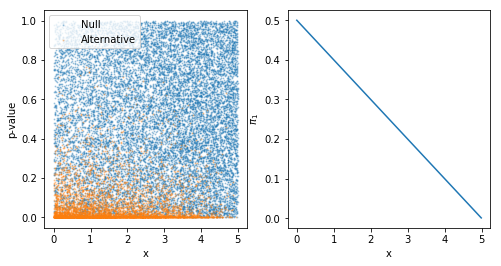

In [2]:
#generate 1d data and plot
plt.figure(figsize = (8,4))
plt.subplot(121)
X = np.random.uniform(high = 5, size = (20000,))
pi1 = (5-X) / 10.0
p, h, x = generate_data_1D_cont(pi1, X)
plt.scatter(x[h==0], p[h==0], 1, alpha = 0.3, label = 'Null')
plt.scatter(x[h==1], p[h==1], 1, alpha = 0.3, label = 'Alternative')
plt.legend()
plt.xlabel('x')
plt.ylabel('p-value')
plt.subplot(122)
x2 = np.arange(0,5,0.01)
y2 = (5-x2) / 10.0
plt.plot(x2,y2)
plt.xlabel('x')
plt.ylabel('$\pi_1$')
plt.savefig('1d1.png')

In [3]:
indices = np.random.permutation(x.shape[0])
A = [indices[:x.shape[0]/3], indices[x.shape[0]/3 : x.shape[0]/3*2], indices[x.shape[0]/3 * 2:]]
train = A
val = [A[1], A[2], A[0]]
test = [A[2], A[0], A[1]]
outputs = []
preds = []
gts = []
for i in range(3):
    network = get_network(num_layers = 10).cuda()
    optimizer = optim.Adagrad(network.parameters(), lr = 0.01)
    train_idx = train[i]
    val_idx = val[i]
    test_idx = test[i]
    
    #network init
    p_target = opt_threshold(x[train_idx], p[train_idx], 10)
    #plt.figure()
    #plt.scatter(x, p_target)
    loss_hist = train_network_to_target_p(network, optimizer, x[train_idx], p_target, num_it = 6000, cuda= True)
    loss_hist2, s, s2 = train_network(network, optimizer, x[train_idx], p[train_idx], num_it = 9000, cuda = True, lambda2_ = 5e3)
    
    scale = get_scale(network, x[val_idx], p[val_idx], cuda = True, lambda2_ = 5e3, fit = True)
    _ = get_scale(network, x[test_idx], p[test_idx], cuda = True, lambda2_ = 5e3, scale = scale)

    n_samples = len(x[test_idx])
    x_input = Variable(torch.from_numpy(x[test_idx].astype(np.float32).reshape(n_samples ,1))).cuda()
    p_input = Variable(torch.from_numpy(p[test_idx].astype(np.float32).reshape(n_samples ,1))).cuda()
    output = network.forward(x_input) * scale
    pred = (p_input < output).cpu().data.numpy()
    pred = pred[:,0].astype(np.float32)
    preds.append(pred)
    
    x2 = np.arange(0, 5, 0.01)
    n_samples = len(x2)
    x_input = Variable(torch.from_numpy(x2.astype(np.float32).reshape(n_samples ,1))).cuda()
    outputs.append(network.forward(x_input) * scale)
    gts.append(h[test_idx])
    
    
    #plt.figure()
    #plt.plot(loss_hist)
    #plt.figure()
    #plt.plot(loss_hist2)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
1.11878281832 0.0499999634922
1.11878281832 0.0584208182991
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4

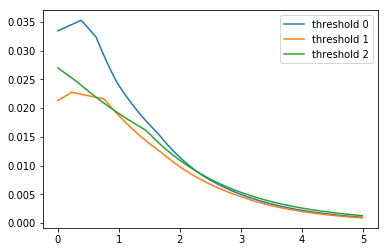

In [5]:
for i,item in enumerate(outputs):
    plt.plot(x2, item.cpu().data.numpy(),  label = 'threshold %d'%(i))
plt.legend()

In [7]:
rejs = [sum(item) for item in preds]
print rejs
print sum(rejs)

preds = np.concatenate(preds)
gts = np.concatenate(gts)
print sum(gts)
print sum(preds)
print sum(preds * gts)
print 1 - sum(preds * gts)/sum(preds)



[821.0, 809.0, 760.0]
2390.0
4983.0
2390.0
2245.0
0.0606694560669


In [3]:
network = get_network().cuda()
optimizer = optim.Adagrad(network.parameters(), lr = 0.01)

In [4]:
print(BH(p))
print(Storey_BH(p))
p_target = np.ones(x.shape) * Storey_BH(p)[1]
loss_hist = train_network_to_target_p(network, optimizer, x, p_target, cuda = True, num_it = 2000)

(1674, 0.0041845069406724437)
(1868, 0.006029419671551255, 0.77441666666666664)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


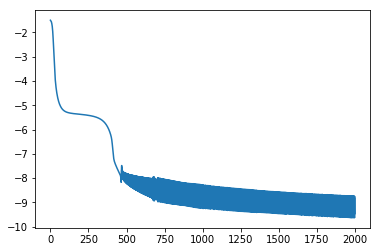

In [5]:
plt.plot(np.log(loss_hist))

In [6]:
optimizer = optim.Adagrad(network.parameters(), lr = 0.01, weight_decay = 0.01)
loss_hist, val_hist, s, s2 = train_network_val(network, optimizer, x, p, num_it = 2000, cuda = True)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


(Variable containing:
 0.1021
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, Variable containing:
1.00000e-03 *
  3.9177
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, Variable containing:
1.00000e-02 *
  3.8368
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)


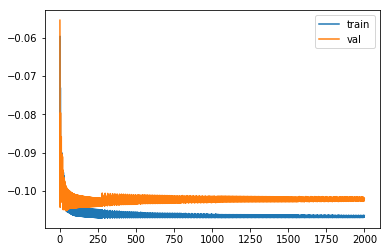

In [7]:
plt.plot(loss_hist, label = 'train')
plt.plot(val_hist, label = 'val')
plt.legend()
print(s,s2, s2/s)

In [8]:
network.cpu()

Model (
  (layers): Sequential (
    (0): Linear (1 -> 10)
    (1): LeakyReLU (0.1)
    (2): Linear (10 -> 10)
    (3): LeakyReLU (0.1)
    (4): Linear (10 -> 10)
    (5): LeakyReLU (0.1)
    (6): Linear (10 -> 10)
    (7): LeakyReLU (0.1)
    (8): Linear (10 -> 10)
    (9): LeakyReLU (0.1)
    (10): Linear (10 -> 10)
    (11): LeakyReLU (0.1)
    (12): Linear (10 -> 1)
    (13): Sigmoid ()
  )
)

In [9]:
n_samples = len(x)
x_input = Variable(torch.from_numpy(x.astype(np.float32).reshape(n_samples ,1)))
p_input = Variable(torch.from_numpy(p.astype(np.float32).reshape(n_samples ,1)))
output = network.forward(x_input)
pred = (p_input < output).data.numpy()
pred = pred[:,0].astype(np.float32)

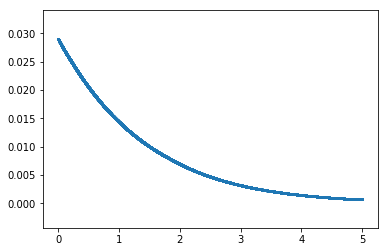

In [10]:
plt.scatter(x, output.data.numpy(), 2)

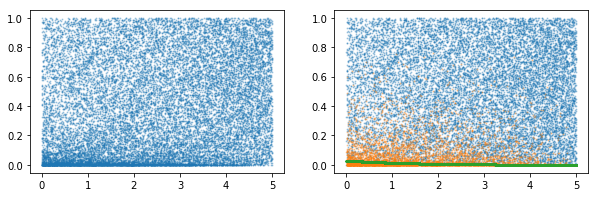

In [11]:
plt.figure(figsize = (10,3))
plt.subplot(1,2,1)
plt.scatter(x, p, 1, alpha = 0.3)
plt.subplot(1,2,2)
plt.scatter(x[h==0], p[h==0], 1, alpha = 0.3)
plt.subplot(1,2,2)
plt.scatter(x[h==1], p[h==1], 1, alpha = 0.3)
plt.scatter(x, output.data.numpy(), 1)

In [12]:
sum(pred)

2121.0

In [13]:
x2 = np.arange(0, 5, 0.01)
n_samples = len(x2)
x_input = Variable(torch.from_numpy(x2.astype(np.float32).reshape(n_samples ,1)))
output2 = network.forward(x_input)


In [14]:
network.cpu()

Model (
  (layers): Sequential (
    (0): Linear (1 -> 10)
    (1): LeakyReLU (0.1)
    (2): Linear (10 -> 10)
    (3): LeakyReLU (0.1)
    (4): Linear (10 -> 10)
    (5): LeakyReLU (0.1)
    (6): Linear (10 -> 10)
    (7): LeakyReLU (0.1)
    (8): Linear (10 -> 10)
    (9): LeakyReLU (0.1)
    (10): Linear (10 -> 10)
    (11): LeakyReLU (0.1)
    (12): Linear (10 -> 1)
    (13): Sigmoid ()
  )
)

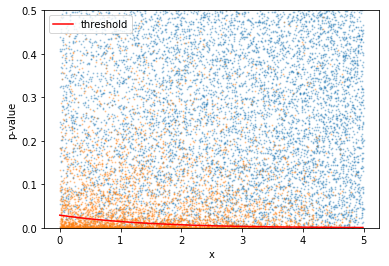

In [15]:
plt.figure()
plt.scatter(x[h==0], p[h==0], 1, alpha = 0.3)
plt.scatter(x[h==1], p[h==1], 1, alpha = 0.3)
plt.plot(x2, output2.data.numpy(), 'r', label = 'threshold')
plt.ylim(0,0.5)
plt.legend()
plt.xlabel('x')
plt.ylabel('p-value')
plt.savefig('1d2.png')

In [16]:
with open('data2.csv', 'w') as f:
    f.write('x_value, p_value, h\n')
    for i in range(len(x)):
        f.write("{}, {}, {}\n".format(x[i],p[i], h[i]))